### Import

In [201]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as functional
import torch
from torch import functional as F

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

### Task_2:

##### Описание задачи

Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

##### Устройство

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


##### Вспомогательные функции

In [3]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

##### Параметры модели

In [4]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

##### Класс Generator

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
#             nn.Conv2d(128, 256, 3),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
#         self.activations = nn.ModuleDict([
#                 ['lrelu', nn.LeakyReLU()],
#                 ['relu', nn.ReLU()]])

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        print('gen_output_shape', img.shape)
        return img

    
gen = Generator().to(device)

In [6]:
g = Generator()

for name, parameter in g.named_parameters():
    print(name, parameter.shape)

model.0.weight torch.Size([128, 100])
model.0.bias torch.Size([128])
model.2.weight torch.Size([256, 128])
model.2.bias torch.Size([256])
model.3.weight torch.Size([256])
model.3.bias torch.Size([256])
model.5.weight torch.Size([512, 256])
model.5.bias torch.Size([512])
model.6.weight torch.Size([512])
model.6.bias torch.Size([512])
model.8.weight torch.Size([1024, 512])
model.8.bias torch.Size([1024])
model.9.weight torch.Size([1024])
model.9.bias torch.Size([1024])
model.11.weight torch.Size([784, 1024])
model.11.bias torch.Size([784])


In [7]:
??g.parameter

Object `g.parameter` not found.


In [8]:
t = torch.LongTensor([[1,2,3], [10,20,30]])

# torch.Tensor((, *t))

t, t.shape

t.size(1)

t.view(1, -1), t.view(1, -1).shape

t.view(-1, *t.shape)
t

tensor([[ 1,  2,  3],
        [10, 20, 30]])

##### Класс CustomLinearLayer


In [9]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

##### Класс Discriminator 

###### Old

##### New

In [275]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3)
        self.relu_1 = nn.LeakyReLU()
        self.conv_2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3)
        self.relu_2 = nn.LeakyReLU()
        self.linear_1 = nn.Linear(in_features=5760, out_features=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        print('discriminator_input_shape', X.shape)
        X = self.conv_1(X)
        X = self.relu_1(X)
        X = self.conv_2(X)
        X = self.relu_2(X)
        print('DBG')
        print('before flatten', X.shape)
        print('agter flatten', torch.flatten(start_dim=1, input=X).shape)
        X = X.view(X.shape[0], -1)
        X = self.linear_1(X)
        X = self.sigmoid(X)
        return X
    
    def __call__(self, *args, **kwargs):
        print('args', args[0].shape)
        print('kwargs', kwargs)
        return super().__call__(*args, **kwargs)

###### Прочее

In [53]:
d = Discriminator()

for name, param in d.named_parameters():
    print(name, param.shape)

conv_1.weight torch.Size([256, 1, 3, 3])
conv_1.bias torch.Size([256])


##### Загрузка датасета

In [12]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

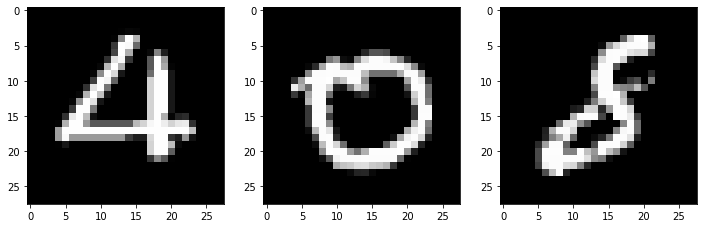

In [13]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

##### Инициализация нейросетей

In [276]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [16]:
d_loss_history = []
g_loss_history = []

##### Training loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/200] [Batch 924/938] [D loss: 0.551622] [G loss: 0.762501]


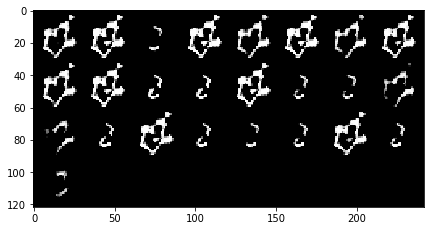

gen_output_shape torch.Size([64, 1, 28, 28])
0 torch.Size([64, 1, 28, 28])
args torch.Size([64, 1, 28, 28])
kwargs {}
discriminator_input_shape torch.Size([64, 1, 28, 28])
DBG
before flatten torch.Size([64, 10, 24, 24])
agter flatten torch.Size([64, 5760])
args torch.Size([64, 1, 28, 28])
kwargs {}
discriminator_input_shape torch.Size([64, 1, 28, 28])
DBG
before flatten torch.Size([64, 10, 24, 24])
agter flatten torch.Size([64, 5760])
args torch.Size([64, 1, 28, 28])
kwargs {}
discriminator_input_shape torch.Size([64, 1, 28, 28])
DBG
before flatten torch.Size([64, 10, 24, 24])
agter flatten torch.Size([64, 5760])
gen_output_shape torch.Size([64, 1, 28, 28])
0 torch.Size([64, 1, 28, 28])
args torch.Size([64, 1, 28, 28])
kwargs {}
discriminator_input_shape torch.Size([64, 1, 28, 28])
DBG
before flatten torch.Size([64, 10, 24, 24])
agter flatten torch.Size([64, 5760])
args torch.Size([64, 1, 28, 28])
kwargs {}
discriminator_input_shape torch.Size([64, 1, 28, 28])
DBG
before flatten torch.

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

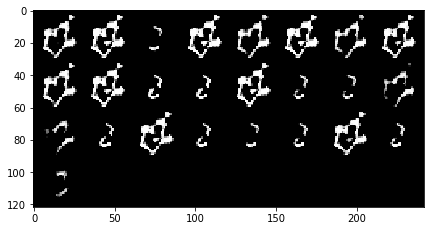

In [278]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        batch_size = imgs.shape[0]
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)
        
        print(0, gen_imgs.shape)
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

#             d_loss_history.append(d_loss)
#             g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()

            

In [273]:
torch.save(generator.state_dict(), "base_model.pth")

### Tests

In [223]:
linear = nn.Linear(in_features=3, out_features=7)
conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,3), padding=0)
conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(4,2), padding=0)

input_ = torch.rand(size=(5,1,5,5))

print('input_shape:')
print(input_.shape)
print('\n', 'input:')
print(input_)

print('\n', 'after_conv')
print(conv(input_).shape)
print(conv(input_))

print('\n', 'after_conv2')
print(conv2(conv(input_)).shape)
print(conv2(conv(input_)))


print('\nconv weight', conv.weight.shape)
print(conv.weight)

print('\nconv2 weight', conv2.weight.shape)
print(conv2.weight)

input_shape:
torch.Size([5, 1, 5, 5])

 input:
tensor([[[[0.1595, 0.9644, 0.6110, 0.9598, 0.5408],
          [0.9272, 0.3370, 0.7536, 0.4816, 0.6344],
          [0.4922, 0.2733, 0.8634, 0.4638, 0.4355],
          [0.7709, 0.9973, 0.1354, 0.5087, 0.9148],
          [0.5587, 0.4460, 0.2348, 0.3247, 0.2660]]],


        [[[0.1814, 0.3062, 0.0611, 0.8790, 0.7326],
          [0.3878, 0.8893, 0.8615, 0.7239, 0.7074],
          [0.5556, 0.3245, 0.7087, 0.8025, 0.5379],
          [0.7628, 0.8869, 0.1692, 0.4250, 0.9963],
          [0.4144, 0.8281, 0.7311, 0.3451, 0.3771]]],


        [[[0.5879, 0.7622, 0.8136, 0.4197, 0.3214],
          [0.8250, 0.5668, 0.7810, 0.4036, 0.7249],
          [0.4876, 0.0486, 0.7567, 0.4985, 0.9326],
          [0.8457, 0.7066, 0.2985, 0.6344, 0.9348],
          [0.5226, 0.7504, 0.9613, 0.8520, 0.3471]]],


        [[[0.7237, 0.8633, 0.4362, 0.4152, 0.3336],
          [0.9278, 0.0710, 0.0645, 0.8061, 0.5643],
          [0.7707, 0.0075, 0.5398, 0.5376, 0.0073],
     